[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OBP_2025/blob/main/analysis_notebooks/petriseq_comparisons.ipynb)

# Clone Github Repo

In [ ]:
!git clone https://github.com/pachterlab/OBP_2025.git
%cd /content/OBP_2025/

In [1]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

import re

# numbers
import numpy as np
import pandas as pd
import scipy

# sc
import scanpy as sc
import anndata

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def gtf2df(gtf: str) -> pd.DataFrame:
    """
    Convert a GTF file to a pandas DataFrame.
    Tested with Ensemble GTF files.
    Parameters
    ----------
    gtf : str
        Path to the GTF file.
    Returns
    -------
    df : pandas.DataFrame
    Examples
    --------
    .. highlight:: python
    .. code-block:: python
        df = gtf2df('ensembl.gtf')
        df.head()
    """

    df = pd.read_csv(gtf, sep='\t', header=None, comment='#')
    df.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

    fields = ['ID', 'Parent', 'Dbxref', 'Name', 'Ontology_term', 'locus_tag', 'old_locus_tag']
    for field in fields:
        df[field] = df['attribute'].apply(lambda x: re.findall(f'{field}=([^"]*)', x)[0].split(';')[0] if f'{field}=' in x else '')

    df.replace('', np.nan, inplace=True)

    df.drop('attribute', axis=1, inplace=True)

    
    return df

In [3]:
gene_mat = pd.read_csv('../petriseq/default_pipeline_results/ecolisamp_v11_threshold_0_mixed_species_gene_matrix.txt', sep = '\t').set_index('Cell Barcode')
old_adata = anndata.AnnData(gene_mat)
old_adata.var.head()

""
NC_000913.3:3'ETS-leuZ
NC_000913.3:C0293
NC_000913.3:aaeA
NC_000913.3:aaeB
NC_000913.3:aaeR


In [4]:
gene_df = old_adata.var.reset_index(names = 'gene_id')
gene_df = gene_df.gene_id.str.split(':', expand = True)
gene_df.columns = ['seqname', 'Name']
gene_df.head()

,seqname,Name
0,NC_000913.3,3'ETS-leuZ
1,NC_000913.3,C0293
2,NC_000913.3,aaeA
3,NC_000913.3,aaeB
4,NC_000913.3,aaeR


In [5]:
normal_gtf = gtf2df('../petriseq/genome/ecolimg1655.gff')
normal_gtf.head()

/var/folders/kj/wm2vrp3x04qgzq18l2rkrcxh0000gn/T/ipykernel_64554/117355437.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


,seqname,source,feature,start,end,score,strand,frame,ID,Parent,Dbxref,Name,Ontology_term,locus_tag,old_locus_tag
0,NC_000913.3,RefSeq,region,1,4641652,.,+,.,NC_000913.3:1..4641652,NaN,taxon:511145,ANONYMOUS,NaN,NaN,NaN
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,gene-b0001,NaN,"ASAP:ABE-0000006,ECOCYC:EG11277,GeneID:944742",thrL,NaN,b0001,NaN
2,NC_000913.3,RefSeq,CDS,190,255,.,+,0,cds-NP_414542.1,gene-b0001,"UniProtKB/Swiss-Prot:P0AD86,GenBank:NP_414542....",NP_414542.1,NaN,b0001,NaN
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,gene-b0002,NaN,"ASAP:ABE-0000008,ECOCYC:EG10998,GeneID:945803",thrA,NaN,b0002,NaN
4,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,cds-NP_414543.1,gene-b0002,"UniProtKB/Swiss-Prot:P00561,GenBank:NP_414543....",NP_414543.1,NaN,b0002,NaN


In [6]:
old_adata.var = pd.merge(gene_df, normal_gtf, on = ['seqname', 'Name'], how = 'left').set_index('ID')
old_adata.var.head()

,seqname,Name,source,feature,start,end,score,strand,frame,Parent,Dbxref,Ontology_term,locus_tag,old_locus_tag
ID,,,,,,,,,,,,,,
gene-b4759,NC_000913.3,3'ETS-leuZ,RefSeq,gene,1991748,1991814,.,-,.,NaN,"ECOCYC:G0-16636,GeneID:63925640",NaN,b4759,NaN
gene-b4806,NC_000913.3,C0293,RefSeq,gene,1196711,1196782,.,+,.,NaN,"ECOCYC:G0-8897,GeneID:71004560",NaN,b4806,NaN
gene-b3241,NC_000913.3,aaeA,RefSeq,gene,3388194,3389126,.,-,.,NaN,"ASAP:ABE-0010631,ECOCYC:G7686,GeneID:947748",NaN,b3241,NaN
gene-b3240,NC_000913.3,aaeB,RefSeq,gene,3386221,3388188,.,-,.,NaN,"ASAP:ABE-0010629,ECOCYC:G7685,GeneID:947747",NaN,b3240,NaN
gene-b3243,NC_000913.3,aaeR,RefSeq,gene,3389520,3390449,.,+,.,NaN,"ASAP:ABE-0010639,ECOCYC:G7688,GeneID:947760",NaN,b3243,NaN


In [7]:
old_adata

AnnData object with n_obs × n_vars = 39183 × 4290
    var: 'seqname', 'Name', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'Parent', 'Dbxref', 'Ontology_term', 'locus_tag', 'old_locus_tag'

## Dataset Loading

In [8]:
adata = anndata.read_h5ad(f"../petriseq/kb_results/kbpython_results/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 216961 × 4639
    layers: 'ambiguous', 'mature', 'nascent'

In [9]:
adata.obs['barcode_1'] = [x[-8:] for x in adata.obs.index.values]
adata.obs['barcode_match'] = [x[:7] + 'N' for x in adata.obs.barcode_1.values]
adata.obs['barcode_match_2'] = [x[-15:-8] for x in adata.obs.index.values]
adata.obs['barcode_match_3'] = [x[:7] for x in adata.obs.index.values]
adata.obs.head()

,barcode_1,barcode_match,barcode_match_2,barcode_match_3
barcode,,,,
AACAGGTAACGAGTCAACTCGG,CAACTCGG,CAACTCGN,AACGAGT,AACAGGT
AACAGGTAACGAGTCACAAGGG,CACAAGGG,CACAAGGN,AACGAGT,AACAGGT
AACAGGTAACGAGTCACACTAG,CACACTAG,CACACTAN,AACGAGT,AACAGGT
AACAGGTAACGAGTCATCCATG,CATCCATG,CATCCATN,AACGAGT,AACAGGT
AACAGGTAACGAGTCATGGTAG,CATGGTAG,CATGGTAN,AACGAGT,AACAGGT


In [11]:
barcode_data = pd.read_csv('../petriseq/barcode_metadata.csv', header=1)
barcode_data = barcode_data[['Round 1 RT: BC Number', 'Oligo Sequence','Oligo Sequence.1','Oligo Sequence.2']]
barcode_data.columns = ['well_number', 'full_barcode_1', 'full_barcode_2', 'full_barcode_3']
barcode_data.head()

,well_number,full_barcode_1,full_barcode_2,full_barcode_3
0,1,/5Phos/GCCAGACAGAGAANNNNNN,/5Phos/GCTTCGCGACCTTACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNGTGTGAAGGTCCTTG
1,2,/5Phos/GCCAGACCAGGAANNNNNN,/5Phos/GCTTCGCAGAGTGACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNTTGGTGAGGTCCTTG
2,3,/5Phos/GCCAGACTCCGAANNNNNN,/5Phos/GCTTCGCTGACTCACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNGTCACAAGGTCCTTG
3,4,/5Phos/GCCAGACGTTGAANNNNNN,/5Phos/GCTTCGCGCCTGTACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNGCGATAAGGTCCTTG
4,5,/5Phos/GCCAGACCTACAANNNNNN,/5Phos/GCTTCGCGTAGTCACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNTACAGCAGGTCCTTG


In [12]:
barcode_data['barcode_match'] = [x[-13:-5] for x in barcode_data.full_barcode_1.values]
barcode_data['barcode_match_2'] = [x[-15:-8] for x in barcode_data.full_barcode_2.values]
barcode_data['barcode_match_3'] = [x[-15:-8] for x in barcode_data.full_barcode_3.values]
barcode_data.head()

,well_number,full_barcode_1,full_barcode_2,full_barcode_3,barcode_match,barcode_match_2,barcode_match_3
0,1,/5Phos/GCCAGACAGAGAANNNNNN,/5Phos/GCTTCGCGACCTTACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNGTGTGAAGGTCCTTG,CAGAGAAN,GACCTTA,GTGTGAA
1,2,/5Phos/GCCAGACCAGGAANNNNNN,/5Phos/GCTTCGCAGAGTGACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNTTGGTGAGGTCCTTG,CCAGGAAN,AGAGTGA,TTGGTGA
2,3,/5Phos/GCCAGACTCCGAANNNNNN,/5Phos/GCTTCGCTGACTCACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNGTCACAAGGTCCTTG,CTCCGAAN,TGACTCA,GTCACAA
3,4,/5Phos/GCCAGACGTTGAANNNNNN,/5Phos/GCTTCGCGCCTGTACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNGCGATAAGGTCCTTG,CGTTGAAN,GCCTGTA,GCGATAA
4,5,/5Phos/GCCAGACCTACAANNNNNN,/5Phos/GCTTCGCGTAGTCACCTCCTAC,AGAATACACGACGCTCTTCCGATCTNNNNNNNTACAGCAGGTCCTTG,CCTACAAN,GTAGTCA,TACAGCA


In [13]:
adata.obs = adata.obs.reset_index()
for x in ['barcode_match', 'barcode_match_2', 'barcode_match_3']:
    barcode_data_temp = barcode_data[['well_number', x]]
    barcode_data_temp.columns = ['well_number'+x, x]
    adata.obs = pd.merge(adata.obs, barcode_data_temp, how = 'left', on = [x])
adata.obs.head()

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,barcode,barcode_1,barcode_match,barcode_match_2,barcode_match_3,well_numberbarcode_match,well_numberbarcode_match_2,well_numberbarcode_match_3
0,AACAGGTAACGAGTCAACTCGG,CAACTCGG,CAACTCGN,AACGAGT,AACAGGT,33,52,76
1,AACAGGTAACGAGTCACAAGGG,CACAAGGG,CACAAGGN,AACGAGT,AACAGGT,27,52,76
2,AACAGGTAACGAGTCACACTAG,CACACTAG,CACACTAN,AACGAGT,AACAGGT,20,52,76
3,AACAGGTAACGAGTCATCCATG,CATCCATG,CATCCATN,AACGAGT,AACAGGT,43,52,76
4,AACAGGTAACGAGTCATGGTAG,CATGGTAG,CATGGTAN,AACGAGT,AACAGGT,19,52,76


In [14]:
well_dict = {}
for i in range(8):
    for x in range(1 + i * 12, 7 + i * 12):
        well_dict[x] = 'exponential'          
    for x in range(7 + i * 12, 13 + i * 12):
        well_dict[x] = 'stationary'         

In [15]:
adata.obs['phase'] = [well_dict[x] for x in adata.obs.well_numberbarcode_match.values]
adata.obs.index = adata.obs['well_numberbarcode_match'].astype('str') + adata.obs['well_numberbarcode_match_2'].astype('str') + adata.obs['well_numberbarcode_match_3'].astype('str')
adata.obs.head()

,barcode,barcode_1,barcode_match,barcode_match_2,barcode_match_3,well_numberbarcode_match,well_numberbarcode_match_2,well_numberbarcode_match_3,phase
335276,AACAGGTAACGAGTCAACTCGG,CAACTCGG,CAACTCGN,AACGAGT,AACAGGT,33,52,76,stationary
275276,AACAGGTAACGAGTCACAAGGG,CACAAGGG,CACAAGGN,AACGAGT,AACAGGT,27,52,76,exponential
205276,AACAGGTAACGAGTCACACTAG,CACACTAG,CACACTAN,AACGAGT,AACAGGT,20,52,76,stationary
435276,AACAGGTAACGAGTCATCCATG,CATCCATG,CATCCATN,AACGAGT,AACAGGT,43,52,76,stationary
195276,AACAGGTAACGAGTCATGGTAG,CATGGTAG,CATGGTAN,AACGAGT,AACAGGT,19,52,76,stationary


In [16]:
gene_df = adata.var.copy().reset_index()
normal_gtf['gene_id'] = normal_gtf.ID.str.split('-', expand = True)[1]
adata.var = pd.merge(gene_df, normal_gtf[normal_gtf['feature'] == 'gene'], on = 'gene_id', how = 'left').set_index('ID')
adata = adata[:,~adata.var.index.isna()]
adata.var.head()

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,gene_id,seqname,source,feature,start,end,score,strand,frame,Parent,Dbxref,Name,Ontology_term,locus_tag,old_locus_tag
ID,,,,,,,,,,,,,,,
gene-b0001,b0001,NC_000913.3,RefSeq,gene,190.0,255.0,.,+,.,NaN,"ASAP:ABE-0000006,ECOCYC:EG11277,GeneID:944742",thrL,NaN,b0001,NaN
gene-b0002,b0002,NC_000913.3,RefSeq,gene,337.0,2799.0,.,+,.,NaN,"ASAP:ABE-0000008,ECOCYC:EG10998,GeneID:945803",thrA,NaN,b0002,NaN
gene-b0003,b0003,NC_000913.3,RefSeq,gene,2801.0,3733.0,.,+,.,NaN,"ASAP:ABE-0000010,ECOCYC:EG10999,GeneID:947498",thrB,NaN,b0003,NaN
gene-b0004,b0004,NC_000913.3,RefSeq,gene,3734.0,5020.0,.,+,.,NaN,"ASAP:ABE-0000012,ECOCYC:EG11000,GeneID:945198",thrC,NaN,b0004,NaN
gene-b0005,b0005,NC_000913.3,RefSeq,gene,5234.0,5530.0,.,+,.,NaN,"ASAP:ABE-0000015,ECOCYC:G6081,GeneID:944747",yaaX,NaN,b0005,NaN


In [17]:
bar_df = old_adata.obs.reset_index()
bar_df = bar_df['Cell Barcode'].str.split('_', expand = True)[[2, 4, 6]]
bar_df.columns = ['well_numberbarcode_match', 'well_numberbarcode_match_2', 'well_numberbarcode_match_3']
bar_df.index = bar_df['well_numberbarcode_match'].astype('str') + bar_df['well_numberbarcode_match_2'].astype('str') + bar_df['well_numberbarcode_match_3'].astype('str')
old_adata.obs = bar_df
old_adata.obs.head()

,well_numberbarcode_match,well_numberbarcode_match_2,well_numberbarcode_match_3
101122,10,11,22
101139,10,11,39
101141,10,11,41
101236,10,12,36
101316,10,13,16


In [39]:
adata = adata[~adata.obs.index.duplicated(), ~adata.var.index.duplicated()]
adata

View of AnnData object with n_obs × n_vars = 205164 × 4495
    obs: 'barcode', 'barcode_1', 'barcode_match', 'barcode_match_2', 'barcode_match_3', 'well_numberbarcode_match', 'well_numberbarcode_match_2', 'well_numberbarcode_match_3', 'phase'
    var: 'gene_id', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'Parent', 'Dbxref', 'Name', 'Ontology_term', 'locus_tag', 'old_locus_tag'
    layers: 'ambiguous', 'mature', 'nascent'

In [41]:
old_adata = old_adata[~old_adata.obs.index.duplicated(), ~old_adata.var.index.duplicated()]
old_adata

View of AnnData object with n_obs × n_vars = 38719 × 4290
    obs: 'well_numberbarcode_match', 'well_numberbarcode_match_2', 'well_numberbarcode_match_3'
    var: 'seqname', 'Name', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'Parent', 'Dbxref', 'Ontology_term', 'locus_tag', 'old_locus_tag'

In [42]:
def make_comp_graph(x_list, y_list, x_name, y_name, 
                    title = None, save = None, log=False):
    if log:
        y = np.log2([y+1 for y in y_list])
        x = np.log2([x+1 for x in x_list])
    else:
        x = x_list
        y = y_list
    pr, p = scipy.stats.pearsonr(x,y)   # Pearson's r
    rho = scipy.stats.spearmanr(x,y).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(x, y)[0]  # Kendall's tau
    m, b = np.polyfit(x, y, 1)
    print(f"Comparing {x_name} to {y_name}")
    print(f"Pearson's r: {pr, p}")
    print(f"Spearman's rho: {rho}")
    print(f"Kendall's tau: {tau}")
    y_true = y
    y_pred = x
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Population variances
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Population standard deviations
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    ccc = numerator / denominator
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hexbin(x, y, gridsize=100, cmap='jet', bins='log')
    plt.plot([np.max([int(min(x)), int(min(y))]), np.min([int(max(x)), int(max(y))])],
             [np.max([int(min(x)), int(min(y))]), np.min([int(max(x)), int(max(y))])],
             label='y=x\nCCC '+str(round(ccc,2)))
    plt.colorbar(label='# of transcripts/bin')
    plt.xlabel(f"{x_name}")
    plt.ylabel(f"{y_name}")
    if title is not None:
        plt.title(title)
    plt.plot(x, [m*l+b for l in x], c='r', label='Regression line\nPearson R'+str(round(pr,2))+'\nSpearman '+r"$\rho$"+' '+str(round(rho,2)))
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()
    plt.close()

Comparing Petri-Seq Pipeline Counts to Kb-python Counts
Pearson's r: (np.float64(0.7803064939139543), np.float64(0.0))
Spearman's rho: 0.7543445838925609
Kendall's tau: 0.7541692147485762


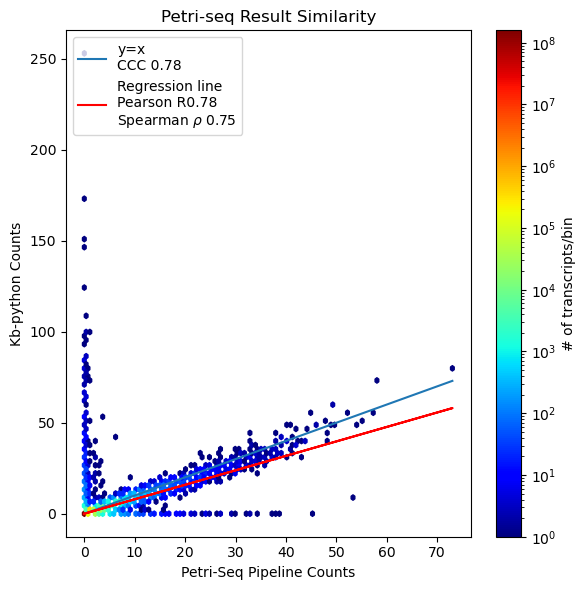

In [43]:
# Loading data
var_intersect = old_adata.var_names.intersection(adata.var_names)#[0:1000]
obs_intersect = old_adata.obs_names.intersection(adata.obs_names)
filtered_old_adata = old_adata[obs_intersect, var_intersect].copy()
filtered_adata = adata[obs_intersect, var_intersect].copy()

make_comp_graph(filtered_old_adata.X.reshape(-1, 1).T[0], filtered_adata.X.toarray().reshape(-1, 1).T[0],
               'Petri-Seq Pipeline Counts', 'Kb-python Counts', 'Petri-seq Result Similarity')

<>:27: SyntaxWarning: invalid escape sequence '\i'
<>:27: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:27: SyntaxWarning: invalid escape sequence '\i'
<>:27: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
/var/folders/kj/wm2vrp3x04qgzq18l2rkrcxh0000gn/T/ipykernel_64554/4096816563.py:27: SyntaxWarning: invalid escape sequence '\i'
  ax1.set_xticklabels(['Stationary \n $\it{E. coli}$', 'Exponential \n $\it{E. coli}$'])
/var/folders/kj/wm2vrp3x04qgzq18l2rkrcxh0000gn/T/ipykernel_64554/4096816563.py:27: SyntaxWarning: invalid escape sequence '\i'
  ax1.set_xticklabels(['Stationary \n $\it{E. coli}$', 'Exponential \n $\it{E. coli}$'])
/var/folders/kj/wm2vrp3x04qgzq18l2rkrcxh0000gn/T/ipykernel_64554/4096816563.py:28: SyntaxWarning: invalid escape sequence '\i'
  ax2.set_xticklabels(['Stationar

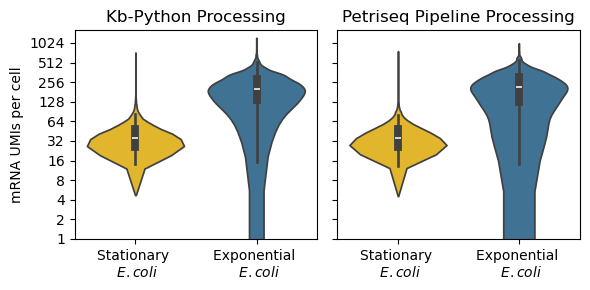

In [44]:
sc.pp.filter_cells(adata, min_genes=15)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(old_adata, min_genes=15)
sc.pp.filter_genes(old_adata, min_cells=10)


old_adata.obs['phase'] = [well_dict[int(x)] for x in old_adata.obs.well_numberbarcode_match.values]

adata.obs['umi'] = adata.X.sum(axis=1)
old_adata.obs['umi'] = old_adata.X.sum(axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.violinplot(adata.obs, x = 'phase', y = 'umi', hue = 'phase', palette = {'stationary':'#ffc60f', 'exponential':'#3274a2'},
              ax = ax1)
sns.violinplot(old_adata.obs, x = 'phase', y = 'umi', hue = 'phase', palette = {'stationary':'#ffc60f', 'exponential':'#3274a2'},
              ax = ax2)
ax1.set_yscale('log', base=2)
ax1.set_yticks([2**x for x in range(0, 11)])
from matplotlib.ticker import ScalarFormatter
for axis in [ax1.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax1.set_ylabel('mRNA UMIs per cell')

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_xticklabels(['Stationary \n $\it{E. coli}$', 'Exponential \n $\it{E. coli}$'])
ax2.set_xticklabels(['Stationary \n $\it{E. coli}$', 'Exponential \n $\it{E. coli}$'])

ax1.set_title('Kb-Python Processing')
ax2.set_title('Petriseq Pipeline Processing')
plt.tight_layout()